# XGBoost implementation

* General documentation : https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster  
* Scikit lean API documentation : https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier           

## Import libriairies

In [3]:
import pandas as pd

import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# area under roc
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve

%matplotlib inline

## Read local dataset

Small dataset for test

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cours BD/loan_default_payment.csv')
df.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,preddef1,preddef2,preddef3
0,41,3,17,12,176,9.3,11.359392,5.008608,1,0.808394,0.788640,0.213043
1,27,1,10,6,31,17.3,1.362202,4.000798,0,0.198297,0.128445,0.436903
2,40,1,15,14,55,5.5,0.856075,2.168925,0,0.010036,0.002987,0.141023
3,41,1,15,14,120,2.9,2.658720,0.821280,0,0.022138,0.010273,0.104422
4,24,2,2,0,28,17.3,1.787436,3.056564,1,0.781588,0.737885,0.436903


**Remove null values in target feature**

In [5]:
print(len(df))
df = df[df.default != ' ']
print(len(df))

850
700


## Split dataset train/test 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["default"]), df.default, test_size=0.2, random_state=256)

## Declaration and model training 

* ``n_estimators`` : iterations number, until this number or early_stopping_rounds be reached  
* ``learning_rate`` : better if the rate is small between 0.1 and 0.01 for a slow convergence
* ``subsample`` : sample training for each tree, here 63% selected data are kept for each one
* ``colsample_bytree`` : columns number selected for each tree, like max_features for a random forest, here a rate is expected
* ``num_parallel_tree`` : trees number trained in parallel, if 10, 10 trees are trained in same time for each iteration
* ``early_stopping_rounds`` : stop training if the model not improve after X iterations, based on the last metric in eval_metric list
* ``eval_set`` : contains a list of tuple datasets (X, y), after every iteration the model is evaluated with these datasets
* ``eval_metric`` : list of metrics to evaluate the model after each iteration : rmse, mae, logloss, aucpr, auc...

### 2 ways to use XGBoost

* **Without parallel training (classic) :**  
Only one forest is trained sequentially, so it's better to have the entire dataset for each tree (bagging and bootsrapping), with deep trees  
In this method, ``num_parallel_tree`` is not used and ``n_estimators`` is the trees number / iterations
 
* **With parallel training :**     
You can train several forests in the same time, so it's better for an optimal parallelisation and model biais, to use bagging and bootsrapping  
By default random forest use square root of features number (bagging), and subsample of 63% on training set (bootstrapping)  
You can use several cpu and thread thanks to ``n_jobs`` parameter  

The purpose, thanks to a greater tree number, is to generate weak learners, less deep, on a dataset sample, their numbers guaranteed something efficient.  

``num_parallel_tree`` is the trees number for each iteration, so a high number can create too many trees => example :  
200 parallel trees during 50 iterations for 3 classes to predict : 200 * 50 * 3 : 30 000 trees

After every itertions, all trees participate to the final prediction

In [40]:
max_features = round(np.sqrt(df.shape[1]) / df.shape[1], 1)
boost = XGBClassifier(max_depth=13, learning_rate=0.01, verbosity=3, n_jobs=4, subsample=0.632, 
                      colsample_bynode=max_features, random_state=256, n_estimators=100, num_parallel_tree = 30)

In [41]:
boost.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric=['auc', 'aucpr'])

[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[17:16:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nod

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.3, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
              nthread=None, num_parallel_tree=30, objective='binary:logistic',
              random_state=256, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.632, verbosity=3)

## Model evaluation
    
Evaluation for each iteration on both datasets, train and test  
2 metrics : area under roc curve and recall

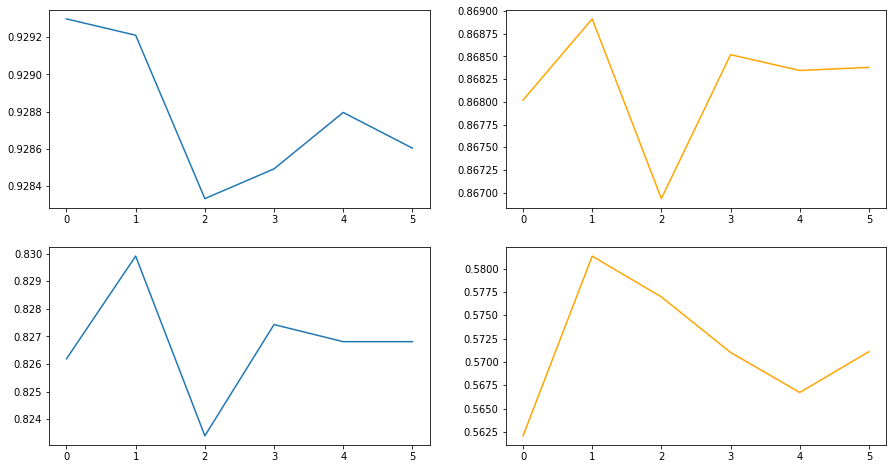

In [42]:
%matplotlib inline

auc_train = boost.evals_result_['validation_0']['auc']
rec_train = boost.evals_result_['validation_0']['aucpr']
auc_test = boost.evals_result_['validation_1']['auc']
rec_test = boost.evals_result_['validation_1']['aucpr']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,8))
ax1.plot(auc_train)
ax2.plot(rec_train, color='orange')
ax3.plot(auc_test)
ax4.plot(rec_test, color='orange')
plt.show()

**Features importance**

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:584: UserWarning: The handle <BarContainer object of 11 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


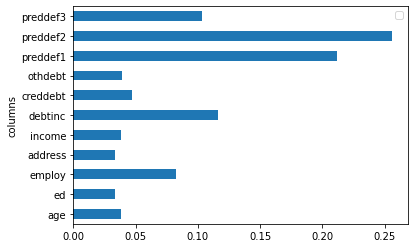

In [45]:
feat_imp = pd.DataFrame({'columns': X_train.columns, 'features_importance': boost.feature_importances_})
ax = feat_imp.plot.barh(x='columns', y='features_importance', label='_Hidden')

**Best trees number for the best iteration**

The metric taken is the last in declaration list (here AUC)

In [72]:
boost.best_ntree_limit

60

**Prediction with the number trees choosen**

In [84]:
probas = boost.predict_proba(X_test, ntree_limit=60)[:,1]

**AUC on test dataset**

In [85]:
roc_auc_score(y_test, probas)

0.8299161230195713

**Recall on test dataset**

In [86]:
precision, recall, thresholds = precision_recall_curve(pd.to_numeric(y_test.ravel()), probas)
metrics.auc(recall, precision)

0.5809800842345786